# **Recommendation Systems**

The below study is focussed on building recommendation systems using popularity & collaborative filtering methods. 


## **1. Importing the necessary libraries, merging the files and cleaning them.**


In [1]:
# All Libraries to Import
!pip install rake_nltk
!pip install scikit-surprise
from rake_nltk import Rake

import pandas as pd
import seaborn as sns

from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise import KNNWithMeans

# Required for Rake
import nltk
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')



  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=150e8e3daee318023cb9816128bea1fcb0c3d1ce25edeea1525c74ed46b42051
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk
     |████████████████████████████████| 11.8MB 4.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618248 sha256=945f2a3776594fd32c52dedefed3d488a2e5db647f28797f373fd9f0eef5cdff
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


### 1.1 Merging the CSV's into One Data Frame 




In [2]:
# Importing a static path from  my google drive; lesser time to type in order to specify the file path
path = '/content/drive/MyDrive/Machine Learning/PGP AIML Course Files/Recommendation Systems/GL-Recommendation_Systems_Assignment/Dataset/'

# Using a loop to merge all data files together
dataSet = pd.DataFrame()
for i in range(1,7):     
    print(f'Merging File Id {i}; before merging the shape is {dataSet.shape}')
    df = pd.read_csv(path+'phone_user_review_file_{}.csv'.format(i), sep=',', error_bad_lines=False, encoding='latin-1')
    dataSet = dataSet.append(df)

print(f'After Merging all 6 files the shape now is {dataSet.shape}')

Merging File Id 1; before merging the shape is (0, 0)
Merging File Id 2; before merging the shape is (374910, 11)
Merging File Id 3; before merging the shape is (489835, 11)
Merging File Id 4; before merging the shape is (802796, 11)
Merging File Id 5; before merging the shape is (901080, 11)
Merging File Id 6; before merging the shape is (1251296, 11)
After Merging all 6 files the shape now is (1415133, 11)


### 1.2 Shape of DataFrame and loading the data




In [3]:
# Exploratory Data Analysis
# 1. Shape of the DataFrame: 1.4M reviews across 11 columns
dataSet.shape

(1415133, 11)

In [4]:
# 2. Checking a few observations
dataSet.head()

# This dataset has phone_url (not required - would be from some site)
# Date - date of the review (interesting to see trends, if time permits can do that analysis)
# Language and Country
# Source of the Review and the domain
# Score given out of maximum score possible
# Extract is the feedback
# Author's Id or name etc.
# Product for which the review was given

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [5]:
# Checking data types
dataSet.info()
# seems to be in order
# Also definately there are some Null Values in Score, Score_Max, Extract and Author which is visible by the difference in the Non-Null count figures

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415133 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 129.6+ MB


In [6]:
dataSet.describe()
# Scoremax as a column can be dropped; we can see all scores are out of 10 only

,score,score_max
count,1.351644e+06,1351644.0
mean,8.007060e+00,10.0
std,2.616121e+00,0.0
min,2.000000e-01,10.0
25%,7.200000e+00,10.0
50%,9.200000e+00,10.0
75%,1.000000e+01,10.0
max,1.000000e+01,10.0


### 1.3 Rounding off scores to the nearest integer




In [7]:
#3. Round of the scores to the nearest integer

dataSet['score'] = round(dataSet['score'],0)

dataSet.head()
# As you can see between this one and the above dataframe which was loaded the scores have been rounded to the nearest integer

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.0,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


### 1.4 Checking and Imputing Missing Values




In [8]:
# There is a possibility that still within these features there could be some values which are blank
# Now doing a for loop to check for these

for col in dataSet.columns:
    print ("# of ", col, " is null =", dataSet[col].isnull().sum())

# As we can see there are 63k reviews where the score is null
# We will impute these values with the score from the same domain

# of  phone_url  is null = 0
# of  date  is null = 0
# of  lang  is null = 0
# of  country  is null = 0
# of  source  is null = 0
# of  domain  is null = 0
# of  score  is null = 63489
# of  score_max  is null = 63489
# of  extract  is null = 19361
# of  author  is null = 63202
# of  product  is null = 1


In [9]:
# Running the code below to impute only the Score; remaining author, extract we are not imputing and these rows will be dropped
# Score_Max is always 10; as shown in the describe above hence it need not be imputed

# We will impute this basis domain and here is the thought
# 1. Domain is basis geography so we will capture how users in a geo think about a phone
# 2. Then there are specialized websites like phonearena where users are more technical than others, for such users we will capture that nuance as well

domainValues = dataSet['domain'].value_counts().index
print(f'There are a total of {len(domainValues)} brands')

for x in domainValues:
    tempDF = dataSet[dataSet['domain'] == x]
    median = tempDF['score'].median()
    missingRecords = dataSet[(dataSet['domain']==x) & (dataSet['score'].isnull())].shape[0]
    if missingRecords != 0:
      print(f'Got a Total Of {missingRecords} records for {x}, setting the median rating to {median} for these.')
      dataSet.loc[(dataSet['domain']==x) & (dataSet['score'].isnull() == True), 'score'] = median # This will impute blanks with median

# As you can see the imputation was absolutely right this has a number of smaller regional websites
# Hence imputing for median basis the domain name was the right thing to do 

# Also note for some of the websites like tiklayaz.com with 12600 records there were no ratings to impute 
# Also for avis.sfr.fr with 10505 again no imputations could be made
# We might have to drop 'nan' records after this imputation

There are a total of 384 brands
Got a Total Of 13 records for amazon.de, setting the median rating to 10.0 for these.
Got a Total Of 33 records for market.yandex.ru, setting the median rating to 8.0 for these.
Got a Total Of 3 records for phonearena.com, setting the median rating to 9.0 for these.
Got a Total Of 29 records for ciao.it, setting the median rating to 8.0 for these.
Got a Total Of 669 records for phonescoop.com, setting the median rating to 9.0 for these.
Got a Total Of 3956 records for svyaznoy.ru, setting the median rating to 10.0 for these.
Got a Total Of 673 records for hotline.ua, setting the median rating to 10.0 for these.
Got a Total Of 6 records for bondfaro.com.br, setting the median rating to 10.0 for these.
Got a Total Of 12602 records for tiklayaz.com, setting the median rating to nan for these.
Got a Total Of 1 records for ciao.es, setting the median rating to 8.0 for these.
Got a Total Of 10505 records for avis.sfr.fr, setting the median rating to nan for th

In [10]:
# Re-running the code to see if any blanks remain
for col in dataSet.columns:
    print ("# of ", col, " is null =", dataSet[col].isnull().sum())

# As reasoned above, these do remain

# of  phone_url  is null = 0
# of  date  is null = 0
# of  lang  is null = 0
# of  country  is null = 0
# of  source  is null = 0
# of  domain  is null = 0
# of  score  is null = 38592
# of  score_max  is null = 63489
# of  extract  is null = 19361
# of  author  is null = 63202
# of  product  is null = 1


In [11]:
# Dropping null values now
dataSet.dropna(inplace=True) 

In [12]:
# Re-running the code for one last time to see if any na remain
for col in dataSet.columns:
    print ("# of ", col, " is null =", dataSet[col].isnull().sum())

# All Clean, ready to proeed

# of  phone_url  is null = 0
# of  date  is null = 0
# of  lang  is null = 0
# of  country  is null = 0
# of  source  is null = 0
# of  domain  is null = 0
# of  score  is null = 0
# of  score_max  is null = 0
# of  extract  is null = 0
# of  author  is null = 0
# of  product  is null = 0


In [13]:
# Also checking rows where score is 0
dataSet[(dataSet == 0).any(axis=1)].shape

# As we can see there are 42 rows where Score is 0
# We will NOT drop these rows 
# It could be that these are actual ratings and for different phones on toneto.net people are upset about

(42, 11)

### 1.5 Duplicate Entries - Check & Removal



In [14]:
# Checking for duplicate feedbacks
# First we will check the count and then we will drop

dataSet.duplicated(keep='first').value_counts()

False    1271437
True        4480
dtype: int64

In [15]:
# Since 4480 is a small number now dropping the records
dataSet.drop_duplicates(inplace=True)

In [16]:
# Now checking to ensure the records were dropped
dataSet.duplicated(keep='first').value_counts()

# as you can see no more duplicates remain

False    1271437
dtype: int64

### 1.6 Selecting 100k records using Random State 612




In [17]:
# Now selecting 1,000,000 rows from the 1.27M rows above using random state 612

sampledSet = dataSet.sample(n=1000000,random_state=612)

### 1.7 EDA and Dropping Irrelavant Features




In [18]:
# SOME EXPLORATORY DATA ANALYSIS
sampledSet.columns

Index(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score',
       'score_max', 'extract', 'author', 'product'],
      dtype='object')

In [19]:
sampledSet.lang.value_counts()
# There are users from multiple languages

en    426706
de    131796
ru    108662
it     88291
es     77127
fr     65138
pt     44579
nl     28799
sv     13439
fi      5318
tr      5101
no      1475
cs      1333
he      1070
pl       376
da       318
hu       269
id       189
ar        11
zh         3
Name: lang, dtype: int64

In [20]:
sampledSet.country.value_counts()
# There are users from multiple countries

us    243847
de    131738
in    100444
ru     90469
it     88291
gb     72938
fr     65138
es     58844
br     42065
nl     18920
ua     18193
se     13439
ar     12353
be      9879
ca      8745
fi      5318
tr      5101
pt      2514
mx      2426
no      1475
cz      1333
ec      1145
il      1070
co       902
au       661
uy       584
cl       458
pl       376
dk       318
ve       307
hu       269
id       189
pe       108
ch        58
nz        42
za        20
ae        11
sg         9
tw         2
cn         1
Name: country, dtype: int64

In [21]:
sampledSet['product'].value_counts()
# There are 51981 products but because of language issues as well some products might have been repeated

Lenovo Vibe K4 Note (White,16GB)                                                                                                  4109
Lenovo Vibe K4 Note (Black, 16GB)                                                                                                 3451
OnePlus 3 (Graphite, 64 GB)                                                                                                       3212
OnePlus 3 (Soft Gold, 64 GB)                                                                                                      2798
Huawei P8lite zwart / 16 GB                                                                                                       2121
                                                                                                                                  ... 
Samsung Galaxy Ace 3 Zwart                                                                                                           1
Apple iPhone 7 (4.70", 128GB, 12MP, Black)             

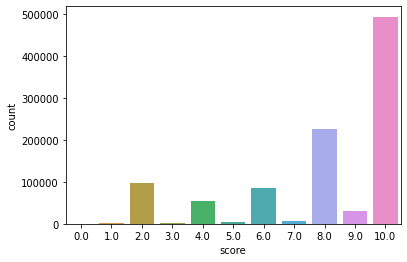

In [22]:
sns.countplot(data=sampledSet, x='score')
# Majority of the time 10 occurs followed by 8; seems like the users are very happy with their phones

In [23]:
# Dropping irrelevant features from a recommendation system perspective
# I am keeping language as a feature for filtering later 
sampledSet = sampledSet[['lang','author','product','score']]

## **Q2. Further EDA & Questions**

### 2.1 Identifying the Most Rated Features




In [24]:
# Will foucus on identifying features in English Language only because of language constraints
onlyEnglishDF = sampledSet[sampledSet['lang'] == 'en']

# initializing the new column
keywordDict = {}

for index, row in onlyEnglishDF.iterrows():
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(row['product'])

    # getting the dictionary with keywords and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # Updating the master dictionary list
    keywordDict.update(key_words_dict_scores)

# output the dictionary sorted by keys in descending order
import operator
keywordDict = dict(sorted(keywordDict.items(), key=operator.itemgetter(1), reverse=True))

In [25]:
list(keywordDict.items())

# We can see from below the following features along with their frequency, sorted in the descending order
# Popular Features include - 5G, a7 processor, cortex processor, unlocked, dust proof, shockproof, outdoor, durable,  battery (6000mah), screen etc.
# If we were doing this on all products incl non-english we were getting a lot of charecters which were difficult to process e.g. 'ø', 'ð²ð¾ð', 'ð¼ñ' etc.

[('wired', 63),
 ('mouse', 42),
 ('xbox', 39),
 ('\x98', 36),
 ('standby', 32),
 ('finger', 32),
 ('1045', 28),
 ('ir', 23),
 ('acacia', 22),
 ('vandot', 22),
 ('xt1032', 21),
 ('((', 21),
 ('5gs', 21),
 ('newly', 21),
 ('released', 21),
 ('57y6255', 21),
 ('wheel', 21),
 ('dpi', 21),
 ('chat', 20),
 ('a7', 20),
 ('cortex', 20),
 ('p710', 20),
 ('f', 20),
 ('mmobiel', 19),
 ('pieces', 19),
 ('x17s', 19),
 ('n8000', 19),
 ('tether', 19),
 ('\x80\x91', 19),
 ('â', 18),
 ('floureon', 18),
 ('multimedia', 18),
 ('unlockedâ', 18),
 ('sandisk', 18),
 ('corning', 18),
 ('joy', 18),
 ('dust', 17),
 ('proof', 17),
 ('durable', 17),
 ('b25', 17),
 ('shockproof', 17),
 ('outdoor', 17),
 ('adr6400', 17),
 ('smartphoneverizon', 17),
 ('34mb', 17),
 ('builders', 17),
 ('bnib', 17),
 ('identify', 17),
 ('orders', 17),
 ('yu', 16),
 ('tundra', 16),
 ('¡', 16),
 ('1800mah', 16),
 ('msm8916', 16),
 ('sdram', 16),
 ('7420', 16),
 ('apq8064t', 16),
 ('311', 15),
 ('included', 15),
 ('penta', 15),
 ('fused

### 2.2 Identifying Users with Most Reviews




In [26]:
# Identify Individuals with most number of reviews

sampledSet['author'].value_counts()[:25] #<- This will give a list of top 25 users with most reviews

# Very Interesting Observation:
# 1. There are feedback items from anonymous users which are clubbed  i.e. Amazon Customer, Cliente Amazon
# 2. We will not considered these anonymous submissions as top submitters.

Amazon Customer       60408
Cliente Amazon        15051
e-bit                  6651
Client d'Amazon        6087
Amazon Kunde           3683
Anonymous              2096
einer Kundin           2065
einem Kunden           1452
unknown                1350
Anonymous              1161
David                   748
Alex                    669
Marco                   662
ÐÐ»ÐµÐºÑÐ°Ð½Ð´Ñ      637
Andrea                  631
Ð¡ÐµÑÐ³ÐµÐ¹            566
Daniel                  562
ÐÐ¼Ð¸ÑÑÐ¸Ð¹          546
ZÃ¡kaznÃ­k              535
Chris                   515
Antonio                 505
Michael                 492
ÐÐ½Ð´ÑÐµÐ¹            468
Francesco               451
ÐÐ»ÐµÐºÑÐµÐ¹          445
Name: author, dtype: int64

In [27]:
# This will now give the list of top 10 submitters excluding anonymous submissions
sampledSet['author'].value_counts()[10:20] #<- This will give a list of top 10 users with most reviews who are not Anonymous

David                 748
Alex                  669
Marco                 662
ÐÐ»ÐµÐºÑÐ°Ð½Ð´Ñ    637
Andrea                631
Ð¡ÐµÑÐ³ÐµÐ¹          566
Daniel                562
ÐÐ¼Ð¸ÑÑÐ¸Ð¹        546
ZÃ¡kaznÃ­k            535
Chris                 515
Name: author, dtype: int64

### 2.3  Products having more than 50 ratings and users who have given more than 50 ratings



In [28]:
# Getting the top 50 products rated by the top 50 users (we will need to remove combined ids e.g. Amazon Customer etc.)
pd.set_option('display.max_rows',100)
sampledSet['author'].value_counts()[:100]

Amazon Customer                                              60408
Cliente Amazon                                               15051
e-bit                                                         6651
Client d'Amazon                                               6087
Amazon Kunde                                                  3683
Anonymous                                                     2096
einer Kundin                                                  2065
einem Kunden                                                  1452
unknown                                                       1350
Anonymous                                                     1161
David                                                          748
Alex                                                           669
Marco                                                          662
ÐÐ»ÐµÐºÑÐ°Ð½Ð´Ñ                                             637
Andrea                                                        

In [29]:
# We will first need to clean the list of users who are Anonymous (this might skew the stats)
# We will only be considering two people with the same name
usersToDrop = ['Amazon Customer','Cliente Amazon','e-bit','Client d\'Amazon','Amazon Kunde','Anonymous','einer Kundin','einem Kunden','unknown','Kindle Customer',
                'Amazon-Kunde','anonym','?????????']

# Dropping anonymous users
cleanUserRatings = sampledSet[~sampledSet['author'].isin(tuple(usersToDrop))]

In [30]:
#Filtering for the products which have more than 50 reviews
cleanUserRatings=cleanUserRatings.groupby('product').filter(lambda x: len(x) >= 50)

# Check to ensure all the products with less than 50 count were removed
cleanUserRatings['product'].value_counts() 

# as you can see the minimum frequency of products is 50

Huawei P8lite zwart / 16 GB                                                                                                               2121
Samsung Galaxy S6 zwart / 32 GB                                                                                                           1837
OnePlus 3 (Graphite, 64 GB)                                                                                                               1777
Lenovo Vibe K4 Note (White,16GB)                                                                                                          1680
Lenovo Vibe K4 Note (Black, 16GB)                                                                                                         1465
                                                                                                                                          ... 
CAT PHONES PHONES S60 Rugged Waterproof Smartphone with integrated FLIR camera                                                              50

In [31]:
# Filtering for the users who have submitted more than 50 reviews
cleanUserRatings=cleanUserRatings.groupby('author').filter(lambda x: len(x) >= 50)

# Resetting the Index 
cleanUserRatings.reset_index()
cleanUserRatings.head()

# Check to ensure the minimum reviews by a person is 50
cleanUserRatings['author'].value_counts()

# as we can see minimum counts by a person are 50

Anonymous             1115
ÐÐ»ÐµÐºÑÐ°Ð½Ð´Ñ     427
ÐÐ¼Ð¸ÑÑÐ¸Ð¹         396
Andrea                 394
Marco                  390
                      ... 
Stephan                 51
Kim                     50
Gaurav                  50
Andre                   50
Chiara                  50
Name: author, Length: 261, dtype: int64

In [32]:
cleanUserRatings.shape
# as you can see 28k records exist after applying the above rules
# i.e. user with mroe than 50 reviews
# products with more than 50 reviews

(28215, 4)

## **Q3. Popularity Based Model**

### The ways of determining which mobile is important can be followed:

1.   Based on popularity of sales (i.e. most selling mobiles)
2.   Based on highest rating irrespective of the number of units sold

Both these can be used but in different places i.e. you can show the most selling products on the website.

You can also show the highest rated mobile phones in different section of the site and look at traction to determine which algorithm works better.



In [33]:
# Popularity based on Product with most Reviews i.e. mobiles most bought
cleanUserRatings['product'].value_counts()[:5] # Top 5 Mobile Basis Most Reviews

Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)                                                                                                                                                391
Lenovo Motorola Moto G Smartphone, 4,5 pollici display HD, processore Qualcomm, memoria 16GB, MicroSIM, Android 4.3 OS, fotocamera da 5 MP, Nero [Germania]                                  270
Huawei P8lite zwart / 16 GB                                                                                                                                                                  211
Huawei P9 Lite Smartphone, LTE, Display 5.2'' FHD, Processore Octa-Core Kirin 650, 16 GB Memoria Interna, 3GB RAM, Fotocamera 13 MP, Single-SIM, Android 6.0 Marshmallow, Bianco [Italia]    207
Huawei P8 Lite Smartphone, Display 5" IPS, Processore Octa-Core 1.5 GHz, Memoria Interna da 16 GB, 2 GB RAM, Fotocamera 13 MP, monoSIM, Android 5.0, Bianco [Italia]                         180
Name: product, dtype: int64

In [34]:
# Popularity Based on Highest Average Score of Products irrespective of how many sales for the products is done it could be 1 or 10,000
cleanUserRatings.groupby('product')['score'].mean().sort_values(ascending=False)[:5] # Top 5 Mobile Basis Average Rating

product
Motorola DROID                                                                                                        10.0
Nokia C2-01.5 Unlocked GSM Phone with 3.2 MP Camera and Music and Video Player--U.S. Version with Warranty (Black)    10.0
Celular LG Messenger GT360                                                                                            10.0
Nokia C2-03 Handy (Dual SIM, Touchscreen Slider, 2MP Kamera, Bluetooth) chrom schwarz                                 10.0
Samsung I9100 Galaxy S II 16GB Sim Free Smartphone - White                                                            10.0
Name: score, dtype: float64

In [35]:
# Exactly as predicted above if we see there is NO INTERSECTION between the top 5 phones basis # of reviews and average number of ratings
# The count determining the average score could be 1 or 1000, it is not being considered in the second algorithm.
# Therefore a better strategy would be to combine the values and take a total score, something like this. 
# This is outside of the scope of this assignment but I am doing this as a practice.

cleanUserRatings.groupby('product')['score'].sum().sort_values(ascending=False)[:5]
# I will rather use this algorithm to show products on my site (if I have any)

product
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)                                                                                                                                                3651.0
Lenovo Motorola Moto G Smartphone, 4,5 pollici display HD, processore Qualcomm, memoria 16GB, MicroSIM, Android 4.3 OS, fotocamera da 5 MP, Nero [Germania]                                  2562.0
Huawei P9 Lite Smartphone, LTE, Display 5.2'' FHD, Processore Octa-Core Kirin 650, 16 GB Memoria Interna, 3GB RAM, Fotocamera 13 MP, Single-SIM, Android 6.0 Marshmallow, Bianco [Italia]    1892.0
Huawei P8lite zwart / 16 GB                                                                                                                                                                  1776.0
Apple iPhone 5s 16GB (ÑÐµÑÑÐ¹ ÐºÐ¾ÑÐ¼Ð¾Ñ)                                                                                                                                               1688.0
Name: score,

## **Q4. & Q6. Collaborative Filtering using SVD incl. RMSE**


In [36]:
# Getting the shape of the data to be analyzed
cleanUserRatings.shape

(28215, 4)

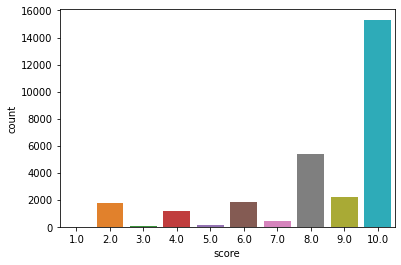

In [37]:
sns.countplot(data=cleanUserRatings, x='score')

# No Zero's
# People are mostly happy with their phones i.e. 10/10 scores for >50% of the sample

In [38]:
# Since we are working with textual data it is important to do one label encoding before the data is fed into the model
# This will help remove any duplications w.r.t. user names etc.
# Getting the data ready for processing

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
revisedUserRatings = cleanUserRatings[['author','product','score']]

# Categorical boolean mask
categorical_feature_mask = revisedUserRatings.dtypes==object

# filter categorical columns using mask and turn it into a list
categorical_cols = revisedUserRatings.columns[categorical_feature_mask].tolist()

revisedUserRatings[categorical_cols] = revisedUserRatings[categorical_cols].apply(lambda col: le.fit_transform(col))

# Clean labelled data will be used for majority of the models
revisedUserRatings.reset_index(inplace=True)
revisedUserRatings.drop('index', axis=1, inplace=True)

# Will be used for some models
reshapedDF = revisedUserRatings.pivot_table(index = 'author', columns ='product', values = 'score').fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
# Transform data to surprise format
reader = Reader(rating_scale=(1, 10))

# This is the surprise sequence
data = Dataset.load_from_df(revisedUserRatings[['author', 'product', 'score']],reader)

In [40]:
# Doing a 25:75 split for test and train respectively
trainset, testset=train_test_split(data,test_size=0.25,random_state=41)

In [41]:
# Create the model and fit it with the training data
svd_model = SVD(n_factors=50, biased=False)
svd_model.fit(trainset)

In [42]:
# Do a prediction of the test data
test_pred=svd_model.test(testset)

In [43]:
# Accuracy measure as RMSE, lower the better
accuracy.rmse(test_pred)

RMSE: 2.7335


2.7334791455518097

## **Q5. & Q6. Collaborative Filtering with KNNWithMeans incl. RMSE** 






### 5.1  User Based Collaborative Filtering



In [44]:
# 1. For User Based:
userSurpriseModel = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
userSurpriseModel.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [45]:
# Predicting the test set on the trained data
test_pred_user = userSurpriseModel.test(testset)

In [46]:
# RMSE for the User Based Model
accuracy.rmse(test_pred_user, verbose=True)

## Has higher accuracy than the SVD model above based on user classification

RMSE: 2.5979


2.597861369288122

### 5.2  Item Based Collaborative Filtering

In [47]:
# 2. For Item Based:
itemSurpriseModel = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
itemSurpriseModel.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [48]:
# Predicting the test set on the trained data
test_pred_item = itemSurpriseModel.test(testset)

In [49]:
# RMSE for the Item Based Model
accuracy.rmse(test_pred_item, verbose=True)

## Has higher accuracy than both the SVD model & the User Based Collaborative Filtering Model above

RMSE: 2.5022


2.5022123165638073

## **7. Predicting Score (Average Rating) for Test Users**

In [50]:
# Predicting average rating for the test users based on the KNNWithMeans User CF Model
actual, predicted = pd.DataFrame(test_pred_user)[['r_ui','est']].mean()
print(f'USER CF MODEL: Predicted Score (avg rating) for test users is : {round(predicted,2)} as compared with the actual rating : {round(actual,2)}')

# Predicting average rating for the test users based on the KNNWithMeans Item CF Model
actual, predicted = pd.DataFrame(test_pred_item)[['r_ui','est']].mean()
print(f'ITEM CF MODEL: Predicted Score (avg rating) for test users is : {round(predicted,2)} as compared with the actual rating : {round(actual,2)}')

USER CF MODEL: Predicted Score (avg rating) for test users is : 8.5 as compared with the actual rating : 8.43
ITEM CF MODEL: Predicted Score (avg rating) for test users is : 8.47 as compared with the actual rating : 8.43


In [51]:
# Predicting for a random item
itemSurpriseModel.predict('217', '2664', verbose=True)

user: 217        item: 2664       r_ui = None   est = 8.46   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='217', iid='2664', r_ui=None, est=8.459949907849346, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [52]:
# Predicting for a random user
userSurpriseModel.predict('62', '3076', verbose=True)

user: 62         item: 3076       r_ui = None   est = 8.46   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='62', iid='3076', r_ui=None, est=8.459949907849346, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

## **8. Findings & Obserations**

1. This data was really huge i.e. greater than 1.5MN Row Items
2. We started by exploring the dataset and the first set of filtering reduced the same to 1.25 MN rows
3. We then did a random state 612 based sleection and selected 100k rows from the data and dropped a number of columns.
4. Thereafter we applied Popularity Based Recommendation System and COllaborative Filtering Methods both SVD and KNN to arrive at recommendations for the user.

**Below are the Observations basis results obtained from the four models:**

1. In terms of Models, going with popularity based model is the best option. I am combining this with some domain expertise as well. During multiple studies for websites like OLX etc. this model works the best. Also the fact that mobiles are more of a peer influenced item therefore buying what is popular can be a significant influencer.

2. Next, in terms of a recommendations system if we compare the two major models w.r.t. RMSE - SVD (2.73) and Collaborative Filtering. Collaborative Filtering has a lower RMSE for both User (2.59) and Item (2.50) based models.

3. Within collaborative filtering Item Based models tend to perform better with a lower RMSE value of 2.50. Also if we look at the mean score of all the recommendations the difference in the Item Based model is 0.04 vs 0.07 for User Based Model

**CONCLUSION:** For a website with mobile phones - the best algorithm would be a popularity recommender (based on domain knowledge) followed by an Item Based Collaborative Filtering Model (based on RMSE).


## **9. Recommending Top 5 Products for Test Users**

In [53]:
def get_recommendations(result, userId,num):
  test_pred=pd.DataFrame(result)
  user_rec = test_pred[test_pred['uid'] == userId][['uid','iid','r_ui','est']].sort_values(by = 'est',ascending = False).head(num)
  return user_rec

# Getting the top 5 Recommendations for the User#174 <-- you can change the user id & no of recommendation to get further recommendations
# get_recommendation(model_to_use, User ID to Recommend, No of Items to Recommend)
get_recommendations(test_pred_item, 174,5)

,uid,iid,r_ui,est
4852,174,2918,10.0,10.0
1291,174,1404,10.0,10.0
2122,174,571,4.0,10.0
2083,174,1641,9.0,10.0
1535,174,1607,8.0,10.0


## **10. Check for Outliers**

In [54]:
# We will check to see where the model was unable to make a prediction i.e. was_impossible = True
def CheckForOutliers(data):
  predCluster, predPossible = [], []
  df = pd.DataFrame(data)
  for user, item, r_ui, est, details in data:
    predCluster.append(details.get('actual_k'))
    predPossible.append(details.get('was_impossible'))

  df['predCluster'] = predCluster
  df['predPossible'] = predPossible

  return(df)

In [55]:
CheckForOutliers(test_pred_user)['predPossible'].value_counts()
# As we can see there are 212 outliers in the prediction userset for whom the prediction was not possible.

False    6842
True      212
Name: predPossible, dtype: int64

## **11. Trying Cross Validation**

In [56]:
# We can use the function which has been written above to recommend the top 5 Items to a User based on the UserCF Model.

# Getting the top 5 Recommendations for the User#174 based on the user KMeans model
get_recommendations(test_pred_user, 174,5)

,uid,iid,r_ui,est
2013,174,901,10.0,10.000000
4852,174,2918,10.0,10.000000
1527,174,943,10.0,10.000000
2122,174,571,4.0,9.933127
5503,174,2262,10.0,9.890041


In [57]:
# Getting the top 5 Recommendations for the User#174 based on the SVD Model
get_recommendations(test_pred, 174,5)

,uid,iid,r_ui,est
2122,174,571,4.0,10.000000
4852,174,2918,10.0,9.946043
5503,174,2262,10.0,9.795371
764,174,1166,6.0,9.667945
2904,174,814,9.0,9.212345


In [58]:
# As We can see both the models are recommending different products with different estimated scores.
# We can do a randomized strategy to show something different for different users & see which model has a better response rate.

## **12. Business Scenario to Use Popularity Based Systems**

Popularity based recommendations systems are very popular but are non-personalized. This is because they only model basis frequency but do not model the interactions whether it is between the user & the product or the product & its features. 

Whenever data availability is limited i.e. we are not capturing rating or feedback for an item from users OR the features of the product we are selling are not on a comparable scale i.e. for general purpose websites. In such cases just recommending what others are buying based on specifics like GEO Tagging etc. can be a very powerful method.

## **13. Business Scenario to Use Collaborative Filtering Based Systems**

Personalization starts here with the Collaborative Filtering Models. The thought is that users who are like minded are tended to behave similarly. This is around interaction between product and users which forms the basis of this model. 

There are two kinds of models here User based and Item Based Filtering. This is when we can use each:

1. IBCF - Item based collaborative filtering system. When users are generally purchasing the products together we can cross recommend the products to the users who have purchased a product A and not product C. If A and C products are always brought together, we can recommend to the same user to buy the product C as well since he has brought product A. Similarity between items is considered to make the recommendations.

2. UBCF - User based collaborative filtering system. We are trying to understand the users who have the similar tastes for products. The similarity of users is based upon their purchase behavior. Person A is similar to person B because both have purchased item x, y and z. 



## **14. Any Other Methods to Improve Recommendations**

1.  There are other methods like **Market Basket Analysis** wherein probability of buying two items together is modelled. In this case considering it is a mobile phone database it is seldom that people would buy two mobile phones together.


2. Next is **Content Based Recommendation Systems** which is also difficult to model here. Yes, indeed we do have features for each model provided but as stated in multiple placed above the data is english as well which created an issue to identify features. What we have is user's feedback about an item and not item features. For content based systems we would need both item and features. Therefore we can't use this model even.

3. **Singular Value Decomposition (SVD)** as a model we can use where we can specify arbitary weights to predict what rating will an individual give to a mobile phone considering he / she has already rated similar products in the past. We have actually only filtered individuals who have given rating for 50 products or more so that is a model that can be tried. 


The Best Models for modelling a product & user problem would be using either Popularity Based Models or using the Collaborative Filtering Models. Both of them have been showcased above.